# Introduction
This notebook is a result of a master's project in supervised learning.  Given the choice of topic, I initally veered directly towards climate change oriented work.  However, I stumbed upon the stop and frisk questionnaire dataset while perusing the NYC Open Data site.  After comparing some of the previous analysis from 2016, I found the line of inquiry much more compelling and fascinating from a social impact point of view.  

With an initial perusal of the data via pivot tables, I was just shocked that there are a disturbing number of disproportionate stops of black children and black individuals at large.  

Racially biased policing is a phrase that's almost redundant for the anti-racist individuals, so I'm not uncovering anything new here.  

But are these findings statistically significant?  Is this dataset truly representative of stop and frisk? Is there anything here in the data that might improve the lives of our NYC neighbors?  I may be asking these questions (and assuming their answers) as an average NYC resident, but I hope to answer them rigorously as a data scientist and as a machine learning engineer.  

As such, I decided to focus on a 2024 exploration of the NYPD generated dataset to find latent truths hidden in the data and attempt to train a predictive model which helps hold the NYPD accountable, but more importantly to provide tooling to aid those who are unjustly targeted.

## A Brief Aside for unexpected empathy
Having turned the corner on much of the EDA, I suddenly understand why officers are so reluctant to take actions because of the "paperwork".  

At 81 discrete data points which need to be vetted and validated, a couple of stop and frisk interactions can easily take up an entire afternoon of data entry.  I say this after seeing the [astronomical stop and frisk numbers prior to 2017](https://datacollaborativeforjustice.org/dashboard-sqf/) and reviewing the data from the same period.  There's orders of magnitude less data collected from that period despite a stop rate of up to 25k stops / 100,000 persons.  One of the primary drivers of keeping these rates as low as they are might very well be the raw data entry time required to process that many events.

But, I digress....

# EDA (Exploratory Data Analysis)
EDA is a method of exploring through a given set of data, finding and cleaning outliers, and ultimately preparing the data for ML model training.  In contrast to many public/open datasets, this dataset is fairly clean and consistent, possibly because of legal oversight.  

Regardless, I will thankfully be able to focus more on analyzing the data than fixing and cleaning it.

In [1]:
# Import all the things...
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

/tmp/ipykernel_343303/4257595237.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
null_strings = ['(null)','#N/A', 'NA', '?', '', ' ', '&&', 'nan']

raw_df = pd.read_csv('./data/sqf-2024.csv',dtype={
        'STOP_FRISK_DATE': 'object',  # Keep as string
        'STOP_FRISK_TIME': 'object'   # Keep as string
    },
    na_values=null_strings,  # Standardize nulls
    low_memory=False)
raw_df.head()

,STOP_ID,STOP_FRISK_DATE,STOP_FRISK_TIME,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,...,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,279772561,2024-01-01,01:58:00,2024,January,Monday,Based on Self Initiated,PO,46,SGT,...,NaN,46.0,A,NaN,1775 CLAY AVE,CLAY AVE,1010576.0,247603.0,PBBX,BRONX
1,279772564,2024-01-01,00:48:00,2024,January,Monday,Based on Self Initiated,PO,120,SGT,...,BLACK HOODIE SWEATSHIRT,67.0,D,NaN,4515 FARRAGUT RD,FARRAGUT RD,1002798.0,171482.0,PBBS,BROOKLYN
2,279772565,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,SCAR ON LIP,68.0,D,NaN,NaN,NaN,977764.0,170616.0,PBBS,BROOKLYN
3,279772566,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,RED JACKET/ RED HAT,68.0,D,NaN,NaN,NaN,977764.0,170616.0,PBBS,BROOKLYN
4,279772567,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,BLACK JACKET,68.0,D,NaN,NaN,NaN,977764.0,170616.0,PBBS,BROOKLYN


## And maybe I spoke too soon
As this dataset is pretty messy under the hood when it comes to specific datatypes.  This is relatively fine for human based consumption, but it will throw our model for a loop down the line during training.  As such, I'll first trim down the number of columns based on sparsity or irrelevance, and categorize them for uniform standardization.

In [3]:
# We have a number of broken columns which should by integer based, but contain null strings as well.  We'll clean those up if they make the final cut...
# broken_columns = [63,72,77,78]
# for v in broken_columns:
#     print(raw_df.columns[v])


# I'll come back to these columns later, but these will be transformed/hot-encoded later for training
# I'm omitting any background or suspects actions as those values should show up within the reason for the stop field, e.g.
# I will skip SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG because the corresonding rows have a criminal possession of a weapon reason already

categorical_columns_to_be_encoded = ['STOP_WAS_INITIATED']

column_categories = {
    'datetime': ['STOP_FRISK_DATE'],
    'numeric': ['STOP_ID', 'OBSERVED_DURATION_MINUTES', 'STOP_DURATION_MINUTES', 'SUSPECT_REPORTED_AGE',	'SUSPECT_WEIGHT', 'STOP_LOCATION_X',
                'STOP_LOCATION_Y'],
    'string': ['MONTH2', 'STOP_WAS_INITIATED', 'ISSUING_OFFICER_RANK', 'SUPERVISING_OFFICER_RANK', 'JURISDICTION_DESCRIPTION', 'SUSPECT_ARREST_OFFENSE',
               'SUMMONS_OFFENSE_DESCRIPTION', 'SUSPECTED_CRIME_DESCRIPTION',  'DEMEANOR_OF_PERSON_STOPPED', 'SUSPECT_SEX', 
               'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_BODY_BUILD_TYPE', 'SUSPECT_OTHER_DESCRIPTION','STOP_LOCATION_BORO_NAME'
    ],
    'boolean': ['OFFICER_EXPLAINED_STOP_FLAG', 'OTHER_PERSON_STOPPED_FLAG', 'SUSPECT_ARRESTED_FLAG',
               'SUMMONS_ISSUED_FLAG', 'OFFICER_IN_UNIFORM_FLAG', 'FRISKED_FLAG',
               'SEARCHED_FLAG', 'ASK_FOR_CONSENT_FLG', 'CONSENT_GIVEN_FLG', 'OTHER_CONTRABAND_FLAG', 'FIREARM_FLAG', 'KNIFE_CUTTER_FLAG',
               'OTHER_WEAPON_FLAG', 'WEAPON_FOUND_FLAG', 'PHYSICAL_FORCE_CEW_FLAG', 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG', 'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
               'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_OTHER_FLAG', 'PHYSICAL_FORCE_RESTRAINT_USED_FLAG', 'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG',
               'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG', 'SEARCH_BASIS_ADMISSION_FLAG',	'SEARCH_BASIS_CONSENT_FLAG',	'SEARCH_BASIS_HARD_OBJECT_FLAG',	
               'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG', 'SEARCH_BASIS_OTHER_FLAG',	'SEARCH_BASIS_OUTLINE_FLAG'],
    # One offs/unique cols
    'height': ['SUSPECT_HEIGHT'],
    'hours': ['STOP_FRISK_TIME'],
}
columns_to_keep = [column for category in column_categories.values() for column in category] 


def clean_numeric(df, cols):
    for col in cols:
        df[col] = (
            df[col]
            # .replace(null_strings, np.nan)
            .apply(pd.to_numeric, errors='coerce')  # Coerce non-numeric to NaN
            .astype('Int64')  # Convert to nullable integer
        )
    return df

def clean_string(df, cols):
    for col in cols:
        df[col] = (
            df[col]
            .astype(str)
            .replace(null_strings, np.nan)
            .str.strip()  # Remove leading/trailing whitespace
        )
    return df

def clean_boolean(df, cols):
    pd.set_option('future.no_silent_downcasting', True) # Future proofing
    for col in cols:
        value_counts = df[col].value_counts()
        # These are boolean fields, so we shouldn't see anything other than two options, whether null or false, but never both.
        if len(value_counts) < 2:  # Force features with only 'Y' values to have 'N' values instead of nulls
            df[col] = df[col].replace([np.nan], 'N')
        df[col] = (
            df[col]
            # .replace(null_strings, False)
            .str.strip()  # Remove leading/trailing whitespace
            .replace({'Y': True, 'N': False, '1': True, '0': False}).infer_objects(copy=False)
            .astype('boolean')  # Pandas' nullable boolean
        )
        num_null_values = df[col].isna().sum()
        assert num_null_values >= 0 if col in ['ASK_FOR_CONSENT_FLG','CONSENT_GIVEN_FLG'] else num_null_values == 0, f"{col}: {num_null_values} <NA> values"
    return df

def clean_datetime(df, cols):
    date_formats = {
        'STOP_FRISK_DATE': '%Y-%M-%d',  # YYYY-MM-DD
    }
    for col in cols:
        df[col] = pd.to_datetime(df[col], format=date_formats.get(col), errors='coerce')
    return df

def clean_hours(df, cols):
    for col in cols:
        df[col] = df[col].str.split(':').str[0]  # Parse out hours from HH:MM:SS format...
        df[col] = pd.to_numeric(df[col],  errors='coerce')
    return df

def clean_height(df, cols, null_strings=null_strings):
    for col in cols:
        df[col] = (
            df[col]
            .astype(str)
            # .replace(null_strings, np.nan)
            .str.extract(r'^(\d+)\.?(\d+)?$')  # Extract feet and inches
            .apply(lambda x: (int(x[0]) * 30.48) + (int(x[1]) * 2.54) if pd.notna(x[0]) else np.nan, axis=1)
            .round()
            .astype('Int64')
        )
    return df    
def filter_bad_data(df):
    # Completely arbitrary cut off for bad data, but I'll assume any ages less than 6 to be errors
    # Similarly, this may remove real, valid data for stops of developmentally disabled persons
    df = df.dropna(subset=['SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT', 'SUSPECT_RACE_DESCRIPTION'])
    df = df[df['SUSPECT_REPORTED_AGE'] >= 6] 
    df = df[df['SUSPECT_HEIGHT'].between(90, 250)] # Min heights of 3ftm to a max of ~8ft
    return df

def clean_data(df, categories, columns_to_keep=columns_to_keep):
    new_df = df[columns_to_keep].copy()
    new_df = clean_datetime(new_df, categories['datetime'])
    new_df = clean_hours(new_df, categories['hours'])
    new_df = clean_string(new_df, categories['string'])
    new_df = clean_numeric(new_df, categories['numeric'])
    new_df = clean_boolean(new_df, categories['boolean'])
    new_df = clean_height(new_df, categories['height'])
    new_df = filter_bad_data(new_df)
    return new_df
cleaned_df = clean_data(raw_df, column_categories)
print(f'There is approximately {len(cleaned_df)/ len(raw_df)}% of the original data after cleaning')
# cleaned_df.head(20)


There is approximately 0.7996927440321437% of the original data after cleaning


## Ongoing Assumptions
Cleaning the data has been more laborious than expected, but I wanted to explicitly call out my subjective modifications.  In particular, I've noted that I'm omitting a number of columns up front due to sparcity (i.e. not enough data) and high correlation/duplicative values (WEAPON_FOUND_FLAG overlaps with the various arrest reason flags like SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG) that will throw off future training.

Similarly, a few of the boolean/flag fields actually contain three types of values due to null strings rather than the expected two.  Initially I was going to assume a false value for all null values here, but I felt it would alter the data too much/not provide enough benefits to modify those values given what they represent.  For transparency, the flags are ASK_FOR_CONSENT_FLG and CONSENT_GIVEN_FLG, with null values representing ~2.49% and 12.26% respectively.

Conversely, there are a number of flag fields which only contain Y values, so I'll be assuming that those null/missing values are indeed false.

In [4]:
# Given the range of clerical/data entry errors in the dataset, 
#   I wanted to filter out values too far outside the norm to ensure accurate exaluations of children facing cases.
def is_plausible_child(row):
    age = row['SUSPECT_REPORTED_AGE']
    height = row['SUSPECT_HEIGHT']
    
    if age >= 18:
        return True
    # Approximate CDC growth chart percentiles (translates roughly to heights of 92cm-120cm for 6 year olds, 139-210cm)
    expected_min = 2.5*age + 77  # ~1st percentile
    expected_max = 6.5*age + 100  # ~99th percentile
    
    return (height >= expected_min) & (height <= expected_max)

plausible_df = cleaned_df[
    (cleaned_df.apply(is_plausible_child, axis=1))
]
len(plausible_df) / len(cleaned_df)
print(f'{len(plausible_df) / len(cleaned_df)}% of data remains after age-height validation')
# 2.5*6 + 77, 2.5*17 + 77, 6.5*6+100, 6.5*17+100

0.999704448056746% of data remains after age-height validation


## Spar-city, here we come
We can see from the vast differences in null rates between the datasets that these flag features are incredibly sparse overall, so normalizing them enables usage of a much larger number of these fields.  That said, we still have some outlier features that I'll consider dropping as we more forwards, specifically weight.

Until then, let's just explore the data as is.

In [5]:
def sparsity_report(df):
    sparsity_report = pd.DataFrame({
        'column': df.columns,
        'null_rate': df.isnull().mean(),
        'unique_values': df.nunique()
    }).sort_values('null_rate', ascending=False)

    print(sparsity_report[['null_rate', 'unique_values']].head(20))
sparsity_report(raw_df)
sparsity_report(plausible_df)

                                                    null_rate  unique_values
PHYSICAL_FORCE_OC_SPRAY_USED_FLAG                    0.999961              1
PHYSICAL_FORCE_WEAPON_IMPACT_FLAG                    0.999567              1
ID_CARD_IDENTIFIES_OFFICER_FLAG                      0.999015              1
SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG         0.995234              1
PHYSICAL_FORCE_CEW_FLAG                              0.995234              1
SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG              0.991807              1
VERBAL_IDENTIFIES_OFFICER_FLAG                       0.987079              1
SUSPECTS_ACTIONS_LOOKOUT_FLAG                        0.987001              1
SHIELD_IDENTIFIES_OFFICER_FLAG                       0.984952              1
OTHER_WEAPON_FLAG                                    0.983771              1
SEARCH_BASIS_ADMISSION_FLAG                          0.981092              1
PHYSICAL_FORCE_OTHER_FLAG                            0.976404              1

## Aggregation at Spar-city
We can see that there still a great deal of sparse data even after the cleaning processes above.  In order to both preserve the data, but also provide more meaningful results, I will aggregate a number of columns/features.

Outcome of Stop: Categorical column with values of "ARRESTED", "SUMMONS ISSUED", and "Innocent/No Action Taken" which will be aggregated from their respective columns while innocent will be the default value in the absence of the others

Officers Used Physical Force: A Boolean feature aggregated from the many physical force features (drawing firearms, using restraint, etc.) 


In [6]:
final_df = plausible_df.copy()
final_df['OUTCOME_OF_STOP'] = np.select(
    condlist=[
        final_df['SUSPECT_ARRESTED_FLAG'],  
        final_df['SUMMONS_ISSUED_FLAG']
    ],
    choicelist=['Arrested', 'Summoned'],
    default='No Charges Filed'
)

PHYSICAL_FORCE_COLUMNS = [
    'PHYSICAL_FORCE_CEW_FLAG',            # Conducted Energy Weapon (Taser)
    'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG',
    'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
    'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG',  # Pepper spray
    'PHYSICAL_FORCE_OTHER_FLAG',
    'PHYSICAL_FORCE_RESTRAINT_USED_FLAG',
    # 'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG', # Omitting as this doesn't reflect the use of force, but a warning.  Also distorts the dataset...
    'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG'
]

# Create aggregated force column (True if ANY force was used)
final_df['OFFICER_USED_FORCE'] = (
    final_df[PHYSICAL_FORCE_COLUMNS]
    .fillna(False)                # Treat missing values as no force
    .any(axis=1)                  # True if any force column is True
    .astype(bool)                 # Ensure boolean dtype
)

final_df['FORCE_TYPE'] = np.select(
    [
        final_df['PHYSICAL_FORCE_WEAPON_IMPACT_FLAG'],
        final_df['PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG'],
        final_df['PHYSICAL_FORCE_CEW_FLAG'], 
        final_df['PHYSICAL_FORCE_OC_SPRAY_USED_FLAG'],
        final_df['PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG'],
        final_df['PHYSICAL_FORCE_OTHER_FLAG'],
        # final_df['PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG'],
        final_df['PHYSICAL_FORCE_RESTRAINT_USED_FLAG']
    ],
    [
        'Weapon Impact',
        'Firearm Drawn', 
        'Taser',
        'Pepper Spray',
        'Handcuffs',
        'Other Physical Force',
        # 'Verbal Commands', 
        'Restraint Used'
    ],
    default='No Force'
)

# Verification
final_df = final_df.reset_index(drop=True)

assert len(final_df['SUSPECT_ARRESTED_FLAG']) == len(final_df)
assert len(final_df['SUMMONS_ISSUED_FLAG']) == len(final_df)
assert final_df[['OUTCOME_OF_STOP']].notna().all().all(), "Null values detected"
print(final_df[['OUTCOME_OF_STOP']].value_counts())
print(final_df[['OFFICER_USED_FORCE']].value_counts())
print(final_df[['FORCE_TYPE']].value_counts())


OUTCOME_OF_STOP 
No Charges Filed    13259
Arrested             6299
Summoned              737
Name: count, dtype: int64
OFFICER_USED_FORCE
False                 15633
True                   4662
Name: count, dtype: int64
FORCE_TYPE          
No Force                15633
Handcuffs                2998
Firearm Drawn             584
Restraint Used            493
Other Physical Force      475
Taser                     103
Weapon Impact               8
Pepper Spray                1
Name: count, dtype: int64


## For the Children
Before analyzing the dataset at large, I did want to segment off the events targeted at children.  Children represent ~19.8% of the total NYC population as of the 2020 census, yet represent 16% of the overall stops.  Given the problems of stop and frisk, this number should be 0, but let's assume that the procedure is legitimate.  Superficially, you'd expect some 1:1ish ratio for any demographic assuming that there's a constant rate of crime for all individuals.  Clearly this assumption doesn't fit reality, but for the sake of argument and statistical clarity, we will assume its true.  

Well, that leads us to the first incongruity, in that young children aren't really committing crimes at equal levels as their older counterparts.  Specifically, while we have zero cases for children under 6, we actually begin to see a great deal of stop and frisk as early as 7 years old.  So to make the numbers a bit more aligned, I will calcuate the percentage of cases for children excluding 5 years old and below for both populations.  In general, rather than representing ~20% of NYC, 6-17 year olds comprise ~14% of the city, edging them towards the terrain of being overpoliced given that they are 15% of the city, but represent 16% of the stop and frisk events. 

In [7]:
number_of_nyc_children = 1740142
number_of_children_under_5 = 475637
total_nyc_population = 8804190
percentage_of_children_in_nyc = (number_of_nyc_children ) / (total_nyc_population ) * 100
percentage_of_6_to_17_children = (number_of_nyc_children - number_of_children_under_5) / (total_nyc_population - number_of_children_under_5) * 100
print(f"6-17 year olds represent {percentage_of_6_to_17_children:.2f}% of all New Yorkers vs the percentage of all children in NYC: {percentage_of_children_in_nyc:.2f}% ")

6-17 year olds represent 15.18% of all New Yorkers vs the percentage of all children in NYC: 19.76% 


In [8]:
# For the children, prepping children specific dataframes for analysis
demographic_features = [
    'SUSPECT_REPORTED_AGE', 
    'SUSPECT_RACE_DESCRIPTION',
    'STOP_WAS_INITIATED',
    'SUSPECTED_CRIME_DESCRIPTION',
    'OFFICER_EXPLAINED_STOP_FLAG',
    'OUTCOME_OF_STOP',
    'FORCE_TYPE',
    # 'SUSPECT_HEIGHT',
    # 'SUSPECT_SEX',
    'STOP_LOCATION_BORO_NAME',
]
demographic_df = final_df[demographic_features].copy()

all_children_df = demographic_df[demographic_df['SUSPECT_REPORTED_AGE'] < 18].copy()
under_13_df = demographic_df[demographic_df['SUSPECT_REPORTED_AGE'] <= 12].copy()
under_13_df['SUSPECT_REPORTED_AGE'].value_counts()
 
print(f'{len(all_children_df)} total records of children targeted stops, where children comprise {len(all_children_df) / len(demographic_df)*100:.2f}% of all stops')

3263 total records of children targeted stops, where children comprise 16.08% of all stops


In [9]:
from pandas import DataFrame
# All the table/graph rendering code...

RACE_LABEL_OVERRIDES = {
    'AMERICAN INDIAN/ALASKAN NATIVE': "American Indian/Alaskan Native",
    "BLACK": "Black",
    "WHITE": "White",
    'BLACK HISPANIC': 'Hispanic (Black)',
    'WHITE HISPANIC': 'Hispanic (White)',
    'MIDDLE EASTERN/SOUTHWEST ASIAN': 'ME/SW Asian',
    'ASIAN / PACIFIC ISLANDER': 'Asian/PI',
}

# Create summary tables
def show_demographic_table(demo_table: DataFrame, title, index_title=""):  
    # Calculate row and column totals for percentage calcs...
    demo_table['ROW TOTAL'] = demo_table.sum(axis=1)
    col_totals = pd.DataFrame([demo_table.sum()], index=['TOTAL'])
   
    # Calculate percentages
    grand_total = demo_table['ROW TOTAL'].sum()
    col_pct = pd.DataFrame([(demo_table.sum() / grand_total * 100).round(1)], index=['% OF TOTAL'])
   
    # Combine all components
    final_table = pd.concat([demo_table, col_totals, col_pct])
    final_table.rename_axis(columns=None)
    
    # Apply styling
    # final_table.index.name = index_title
    styled = final_table.style.set_caption(title)
    
    
    # Format only numeric cells with integers (avoiding the percentage row)
    styled = styled.format('{:,}', subset=pd.IndexSlice[demo_table.index.tolist() + ['TOTAL'], :])
    
    # Format percentage row
    styled = styled.format('{:.1f}%', subset=pd.IndexSlice['% OF TOTAL', :])
    
    # Add other styling
    styled = styled.background_gradient(cmap='Blues', subset=pd.IndexSlice[demo_table.index, :])
    styled = styled.set_table_styles([
        {'selector': 'tr:nth-last-child(2)', 'props': 'border-top: 2px solid black;'},
        {'selector': 'tr:last-child', 'props': 'border-top: 1px solid black;'},
        {'selector': '.row_heading', 'props': 'text-align: left;'},
        {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.2em; font-weight: bold;'}
    ])
    # styled = styled.highlight_max(axis=0, subset=pd.IndexSlice[demo_table.index, :], color='#ffeb99')
    return styled

def plot_stop_outcomes(df, n_reasons=5, figsize=(14, 8), plot_title = "Policing Outcomes by Race and Stop Reason of 6-12 Year Olds"):
    # 1. Aggregate data safely
    outcomes = (
        df.groupby(['SUSPECT_RACE_DESCRIPTION', 
                   'SUSPECTED_CRIME_DESCRIPTION', 
                   'OUTCOME_OF_STOP'])
        .size()
        .unstack()
        .fillna(0)
    )
    
    # 2. Get top reasons that actually exist in data
    valid_reasons = df['SUSPECTED_CRIME_DESCRIPTION'].value_counts().nlargest(n_reasons).index
    valid_reasons = [r for r in valid_reasons if r in outcomes.index.get_level_values(1)]
    
    # 3. Set up plot
    n_cols = min(3, len(valid_reasons))
    n_rows = (len(valid_reasons) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    # 4. Color palette for whatever outcomes exist
    palette = {
        'Arrested': '#e63946',
        'Summoned': '#457b9d', 
        'No Charges Filed': '#a8dadc',
        'Other': '#1d3557'  # Fallback
    }
    
    # 5. Plot each reason
    for i, reason in enumerate(valid_reasons):
        ax = axes[i]
        reason_data = outcomes.xs(reason, level='SUSPECTED_CRIME_DESCRIPTION')
        
        # Normalize and get ACTUAL existing outcomes
        reason_data = reason_data.div(reason_data.sum(axis=1), axis=0)
        existing_outcomes = [col for col in reason_data.columns if reason_data[col].sum() > 0]
        
        labels = [
            RACE_LABEL_OVERRIDES.get(race, race[:12] + '...' if len(race) > 12 else race)
            for race in reason_data.index
        ]
        
        # Dynamically plot available outcomes
        reason_data[existing_outcomes].plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[palette.get(o, '#999999') for o in existing_outcomes],
            width=0.8
        )
        
        # Set custom labels
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        # Formatting
        ax.set_title(f"{reason[:20]}..." if len(reason) > 20 else reason, pad=10)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.tick_params(axis='x', rotation=45)
        
        # Only show legend on first plot
        if i != 0:
            ax.get_legend().remove()
        else:
            ax.legend(title='Outcome', bbox_to_anchor=(1, 1))

    # Clean up empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(plot_title, y=1.02, fontsize=14)
    plt.show()

### Glossary of Police Terms 
Most of this type of analysis is outside my wheelhouse, so we're learning about these terms together

#### Stop Initiated Codes
Surprisingly, there is no official NYPD documentation for these values that I could find, even in its data dictionary.  Moreover, these code have changed over time in the stop and frisk datasets themselves.  As such, this is the best that I could glean from searching more broadly for reader transparency.

- Based on C/W on Scene: Based upon a complaint/witness or other third party
- Based on Radio Run: Officer was dispatched to investigate by headquarters
- Based on Self Initiated:  Officer initiated the stop and frisk interaction

#### Crime Definitions
Below is a glossary of common crime categories used in NYPD stop-and-frisk data, with definitions and direct references to the relevant sections of New York State law on [nysenate.gov](https://www.nysenate.gov/legislation/laws/PEN). Each entry includes a brief definition and a markdown link to the official legislative text where available.

They are ordered by most severe to least severe

## Misdemeanors

**ASSAULT (Third Degree)**  
Causing physical injury to another person.  
[§120.00 Assault in the third degree](https://www.nysenate.gov/legislation/laws/PEN/120.00)

**MENACING (Second Degree)**  
Placing another person in fear of imminent physical injury.  
[§120.14 Menacing in the second degree](https://www.nysenate.gov/legislation/laws/PEN/120.14)

**RECKLESS ENDANGERMENT (Second Degree)**  
Recklessly creating a substantial risk of serious physical injury.  
[§120.20 Reckless endangerment in the second degree](https://www.nysenate.gov/legislation/laws/PEN/120.20)

**FORCIBLE TOUCHING**  
Intentionally touching another person in a sexual manner without consent.  
[§130.52 Forcible touching](https://www.nysenate.gov/legislation/laws/PEN/130.52)

**CRIMINAL POSSESSION OF A WEAPON (CPW) (Misdemeanor Levels)**  
Possessing certain weapons unlawfully.  
[§265.01 Criminal possession of a weapon in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/265.01)

**CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE (Misdemeanor Levels)**  
Possessing small amounts for personal use.  
[§220.03 Criminal possession of a controlled substance in the seventh degree](https://www.nysenate.gov/legislation/laws/PEN/220.03)

**CRIMINAL SALE OF MARIHUANA (Misdemeanor Levels)**  
Unlawfully selling small amounts of marijuana.  
[§221.40 Criminal sale of marihuana in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/221.40) *(Repealed, but historically relevant)*

**CRIMINAL POSSESSION OF MARIHUANA (Misdemeanor Levels)**  
Unlawful possession of marijuana.  
[§221.10 Criminal possession of marihuana in the fifth degree](https://www.nysenate.gov/legislation/laws/PEN/221.10) *(Repealed, but historically relevant)*

**CRIMINAL TRESPASS (Second Degree)**  
Knowingly entering or remaining unlawfully in a dwelling.  
[§140.15 Criminal trespass in the second degree](https://www.nysenate.gov/legislation/laws/PEN/140.15)

**CRIMINAL MISCHIEF (Fourth Degree)**  
Intentionally damaging another person's property.  
[§145.00 Criminal mischief in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/145.00)

**PETIT LARCENY**  
Theft of property valued at $1,000 or less.  
[§155.25 Petit larceny](https://www.nysenate.gov/legislation/laws/PEN/155.25)

**THEFT OF SERVICES**  
Obtaining services without paying.  
[§165.15 Theft of services](https://www.nysenate.gov/legislation/laws/PEN/165.15)

**CRIMINAL POSSESSION OF STOLEN PROPERTY (CPSP) (Misdemeanor Levels)**  
Knowingly possessing stolen property valued at $1,000 or less.  
[§165.40 Criminal possession of stolen property in the fifth degree](https://www.nysenate.gov/legislation/laws/PEN/165.40)

**AUTO STRIPPING (Misdemeanor Levels)**  
Removing parts from a vehicle without the owner's permission.  
[§165.09 Auto stripping in the third degree](https://www.nysenate.gov/legislation/laws/PEN/165.09)

**UNAUTHORIZED USE OF A VEHICLE (Third Degree)**  
Using a vehicle without the owner's consent.  
[§165.05 Unauthorized use of a vehicle in the third degree](https://www.nysenate.gov/legislation/laws/PEN/165.05)

**MAKING GRAFFITI**  
Marking property with graffiti without the owner's permission.  
[§145.60 Making graffiti](https://www.nysenate.gov/legislation/laws/PEN/145.60)

**CRIMINAL POSSESSION OF FORGED INSTRUMENT (Misdemeanor Levels)**  
Possessing a forged document with intent to defraud.  
[§170.20 Criminal possession of a forged instrument in the third degree](https://www.nysenate.gov/legislation/laws/PEN/170.20)

**PROSTITUTION**  
Engaging in, agreeing to, or offering sexual conduct for a fee.  
[§230.00 Prostitution](https://www.nysenate.gov/legislation/laws/PEN/230.00)

## Felonies

**MURDER**  
Intentionally causing the death of another person.  
[§125.25 Murder in the second degree](https://www.nysenate.gov/legislation/laws/PEN/125.25)

**TERRORISM**  
Acts intended to intimidate or coerce a civilian population or influence government policy.  
[§490.25 Crime of terrorism](https://www.nysenate.gov/legislation/laws/PEN/490.25)

**RAPE**  
Engaging in sexual intercourse with another person without consent.  
[§130.35 Rape in the first degree](https://www.nysenate.gov/legislation/laws/PEN/130.35)

**ROBBERY**  
Forcibly stealing property from another by force or threat of force.  
[§160.15 Robbery in the first degree](https://www.nysenate.gov/legislation/laws/PEN/160.15)

**BURGLARY**  
Illegally entering a building with intent to commit a crime, usually theft.  
[§140.30 Burglary in the first degree](https://www.nysenate.gov/legislation/laws/PEN/140.30)

**ASSAULT (First Degree)**  
Causing serious physical injury to another person with intent.  
[§120.10 Assault in the first degree](https://www.nysenate.gov/legislation/laws/PEN/120.10)

**CRIMINAL SALE OF CONTROLLED SUBSTANCE**  
Selling illegal drugs or controlled substances.  
[§220.43 Criminal sale of a controlled substance in the first degree](https://www.nysenate.gov/legislation/laws/PEN/220.43)

**CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE (Felony Levels)**  
Possessing large quantities or with intent to sell.  
[§220.16 Criminal possession of a controlled substance in the third degree](https://www.nysenate.gov/legislation/laws/PEN/220.16)

**GRAND LARCENY**  
Theft of property valued above $1,000.  
[§155.30 Grand larceny in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/155.30)

**GRAND LARCENY AUTO**  
Theft of a motor vehicle valued above $1,000.  
[§155.30(8) Grand larceny in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/155.30)

**CRIMINAL POSSESSION OF A WEAPON (CPW) (Felony Levels)**  
Possessing a firearm or other weapon unlawfully (felony levels).  
[§265.03 Criminal possession of a weapon in the second degree](https://www.nysenate.gov/legislation/laws/PEN/265.03)

**CRIMINAL POSSESSION OF STOLEN PROPERTY (CPSP) (Felony Levels)**  
Knowingly possessing stolen property valued above $1,000.  
[§165.45 Criminal possession of stolen property in the third degree](https://www.nysenate.gov/legislation/laws/PEN/165.45)

**AUTO STRIPPING (Felony Levels)**  
Removing parts from a vehicle causing damage over $1,000.  
[§165.11 Auto stripping in the first degree](https://www.nysenate.gov/legislation/laws/PEN/165.11)

---

## Felony or Misdemeanor (Depends on Circumstances)

Some crimes can be classified as either a misdemeanor or felony depending on the value involved, the presence of weapons, injury, or prior convictions:

- ASSAULT
- CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE
- CRIMINAL POSSESSION OF A WEAPON (CPW)
- CRIMINAL POSSESSION OF STOLEN PROPERTY (CPSP)
- AUTO STRIPPING
- CRIMINAL POSSESSION OF FORGED INSTRUMENT
- CRIMINAL TRESPASS
- CRIMINAL MISCHIEF
- UNAUTHORIZED USE OF A VEHICLE
- CRIMINAL SALE OF MARIHUANA


In [10]:
under_13_demo_table = (
    under_13_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "All Stops of Children under 13 by Age and Race", 'Age / Suspect')


SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,39.0,3.0,1.0,6.0,9.0,58.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


## Exploring the data
In general, I will briefly analyze three slices of New Yorkers, children under 13, all children under 18, and all New Yorkers at large.  Each analysis will largely follow a loose sequence of events defined in the data, namely who initated the stop, for what reason, what type of force did the police use if any, and ultimately to what outcome for the targeted individual.

In [11]:
under_13_demo_table = (
    under_13_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "What inititated the stop of Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,12.0,1.0,0.0,1.0,1.0,15.0
Based on Radio Run,0.0,32.0,3.0,0.0,10.0,9.0,54.0
Based on Self Initiated,1.0,9.0,1.0,1.0,0.0,3.0,15.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


In [12]:
under_13_demo_table = (
    under_13_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "Why Did Officers Stop Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,5.0,1.0,1.0,1.0,2.0,10.0
BURGLARY,1.0,3.0,0.0,0.0,0.0,0.0,4.0
CPW,0.0,11.0,3.0,0.0,7.0,1.0,22.0
CRIMINAL MISCHIEF,0.0,2.0,0.0,0.0,1.0,1.0,4.0
CRIMINAL TRESPASS,0.0,0.0,0.0,0.0,0.0,2.0,2.0
GRAND LARCENY,0.0,3.0,0.0,0.0,0.0,1.0,4.0
GRAND LARCENY AUTO,0.0,1.0,0.0,0.0,1.0,0.0,2.0
MENACING,0.0,3.0,1.0,0.0,0.0,0.0,4.0
OTHER,0.0,1.0,0.0,0.0,0.0,0.0,1.0
PETIT LARCENY,0.0,4.0,0.0,0.0,0.0,0.0,4.0


In [13]:
# print("Unique values in OFFICER_USED_FORCE:", under_13_df['OFFICER_USED_FORCE'].unique())
# print("Unique values in SUSPECT_RACE_DESCRIPTION:", under_13_df['SUSPECT_RACE_DESCRIPTION'].unique())


under_13_demo_table = (
    under_13_df.groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "Why Did Officers Stop Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Firearm Drawn,0.0,1.0,0.0,0.0,0.0,1.0,2.0
Handcuffs,0.0,9.0,1.0,0.0,1.0,2.0,13.0
No Force,1.0,42.0,4.0,1.0,10.0,10.0,68.0
Restraint Used,0.0,1.0,0.0,0.0,0.0,0.0,1.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


In [14]:
under_13_demo_table = (
    under_13_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "What Were the Outcomes of Stops of Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Arrested,0.0,27.0,0.0,0.0,1.0,1.0,29.0
No Charges Filed,1.0,26.0,5.0,1.0,10.0,12.0,55.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


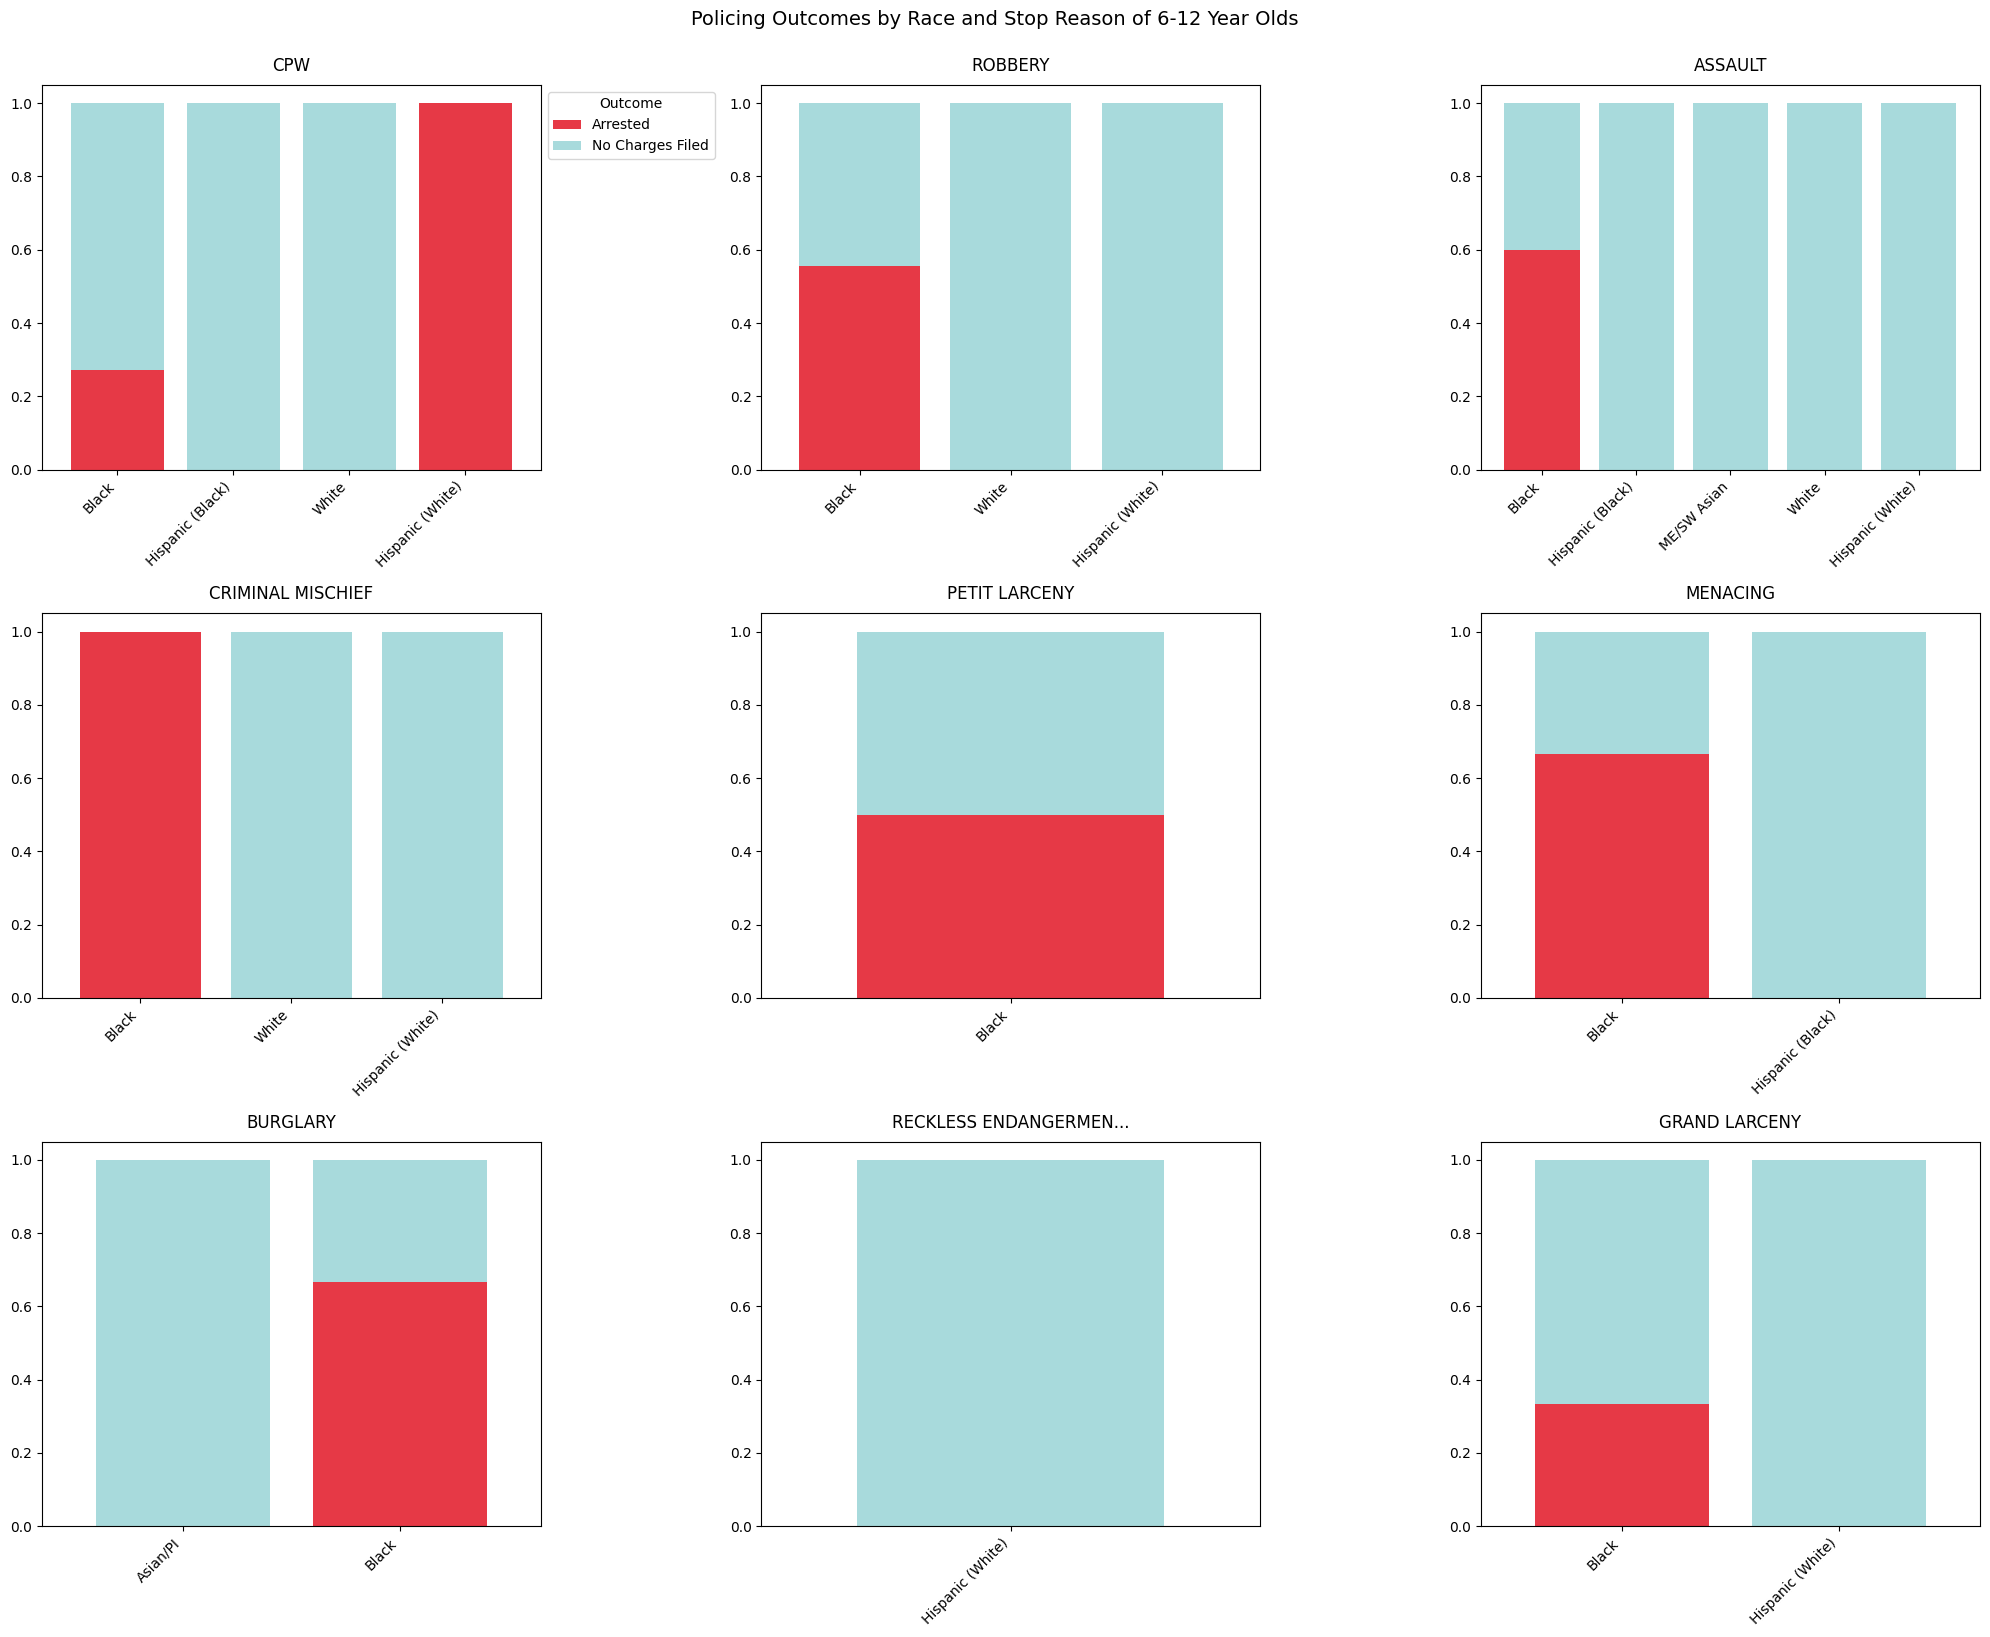

In [15]:
plot_stop_outcomes(under_13_df, figsize=(20,16), n_reasons=9)

In [16]:
# If you want to take a look at the raw data:
under_13_df

,SUSPECT_REPORTED_AGE,SUSPECT_RACE_DESCRIPTION,STOP_WAS_INITIATED,SUSPECTED_CRIME_DESCRIPTION,OFFICER_EXPLAINED_STOP_FLAG,OUTCOME_OF_STOP,FORCE_TYPE,STOP_LOCATION_BORO_NAME
349,12,BLACK,Based on C/W on Scene,ROBBERY,True,No Charges Filed,Restraint Used,BRONX
534,10,WHITE HISPANIC,Based on Radio Run,CRIMINAL MISCHIEF,True,No Charges Filed,No Force,BROOKLYN
1487,12,BLACK,Based on C/W on Scene,PETIT LARCENY,True,No Charges Filed,No Force,BRONX
2508,12,WHITE,Based on Radio Run,CPW,True,No Charges Filed,No Force,STATEN ISLAND
2509,11,WHITE,Based on Radio Run,CPW,True,No Charges Filed,No Force,STATEN ISLAND
...,...,...,...,...,...,...,...,...
19422,11,BLACK,Based on Radio Run,ASSAULT,True,No Charges Filed,No Force,BROOKLYN
19968,9,BLACK,Based on Radio Run,ROBBERY,True,Arrested,No Force,QUEENS
19969,12,BLACK,Based on Radio Run,ROBBERY,True,No Charges Filed,No Force,QUEENS
19970,12,BLACK,Based on Radio Run,ROBBERY,True,Arrested,No Force,QUEENS


### Not Off to the Best Start...
Thankfully, there are very few stops of pre-teens relative to the general population, but it is still too high.  

We've got kids as young as 7 being stopped by the police.  The earliest arrest was aged 9 for robbery.  Black and Black/Hispanic children make up the overwhelming majority of both stops as well as arrests.  They also comprise the entirety of Menacing charges and arrests, and seem to be the only children arrested for criminal mischief, assault, or robbery.  

One could certainly just come to a conclusion that these children are legitimate criminals at this age reinforcing debunked notions of super predators, but its important to call out that an arrest is not a conviction as well as the completely subjective nature of these interactions.  Any officer could use their discretion to not charge these children, as we see pretty consistently for those children possessing a lighter skin tone.


At 84 records, there's not enough statistical power to definitely prove any biases here, but there's certainly a great deal of smoke even if we can't see the fire.

But onto the Under 18 cohort...

In [17]:
all_children_demo_table = (
    all_children_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "All Stops of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,0.0,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,0.0,39.0,3.0,1.0,6.0,9.0,58.0
13,0.0,2.0,151.0,11.0,6.0,13.0,32.0,215.0
14,2.0,2.0,329.0,28.0,4.0,32.0,77.0,474.0
15,0.0,20.0,470.0,72.0,9.0,24.0,137.0,732.0
16,0.0,8.0,566.0,75.0,7.0,26.0,157.0,839.0


In [18]:
all_children_demo_table = (
    all_children_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "What inititated the stop of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,8.0,197.0,36.0,3.0,14.0,78.0,336.0
Based on Radio Run,3.0,28.0,999.0,138.0,29.0,99.0,265.0,"1,561.0"
Based on Self Initiated,0.0,13.0,975.0,108.0,3.0,27.0,240.0,"1,366.0"
TOTAL,3.0,49.0,"2,171.0",282.0,35.0,140.0,583.0,"3,263.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.6%,1.1%,4.3%,17.9%,100.0%


In [19]:
all_children_demo_table = (
    all_children_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "All Stops of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,1.0,3.0,147.0,24.0,4.0,14.0,61.0,254.0
AUTO STRIPPIG,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
BURGLARY,0.0,2.0,47.0,10.0,1.0,16.0,11.0,87.0
CPSP,0.0,0.0,3.0,2.0,0.0,1.0,2.0,8.0
CPW,0.0,5.0,"1,060.0",113.0,15.0,37.0,235.0,"1,465.0"
CRIMINAL MISCHIEF,1.0,0.0,24.0,3.0,3.0,13.0,7.0,51.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL POSSESSION OF MARIHUANA,0.0,0.0,5.0,0.0,0.0,0.0,2.0,7.0
CRIMINAL SALE OF MARIHUANA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
CRIMINAL TRESPASS,0.0,4.0,53.0,3.0,2.0,5.0,17.0,84.0


In [20]:
all_children_demo_table = (
    all_children_df.groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "Types of Force Used Against All Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Firearm Drawn,0.0,0.0,74.0,9.0,2.0,3.0,16.0,104.0
Handcuffs,0.0,9.0,342.0,51.0,2.0,15.0,82.0,501.0
No Force,3.0,38.0,"1,624.0",205.0,30.0,119.0,455.0,"2,474.0"
Other Physical Force,0.0,2.0,52.0,7.0,1.0,2.0,8.0,72.0
Restraint Used,0.0,0.0,71.0,7.0,0.0,1.0,20.0,99.0
Taser,0.0,0.0,7.0,3.0,0.0,0.0,1.0,11.0
Weapon Impact,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
TOTAL,3.0,49.0,"2,171.0",282.0,35.0,140.0,583.0,"3,263.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.6%,1.1%,4.3%,17.9%,100.0%


In [21]:
all_children_demo_table = (
    all_children_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "Outcome of Stops of All Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Arrested,1.0,19.0,753.0,105.0,9.0,44.0,176.0,"1,107.0"
No Charges Filed,2.0,27.0,"1,364.0",166.0,25.0,93.0,381.0,"2,058.0"
Summoned,0.0,3.0,54.0,11.0,1.0,3.0,26.0,98.0
TOTAL,3.0,49.0,"2,171.0",282.0,35.0,140.0,583.0,"3,263.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.6%,1.1%,4.3%,17.9%,100.0%


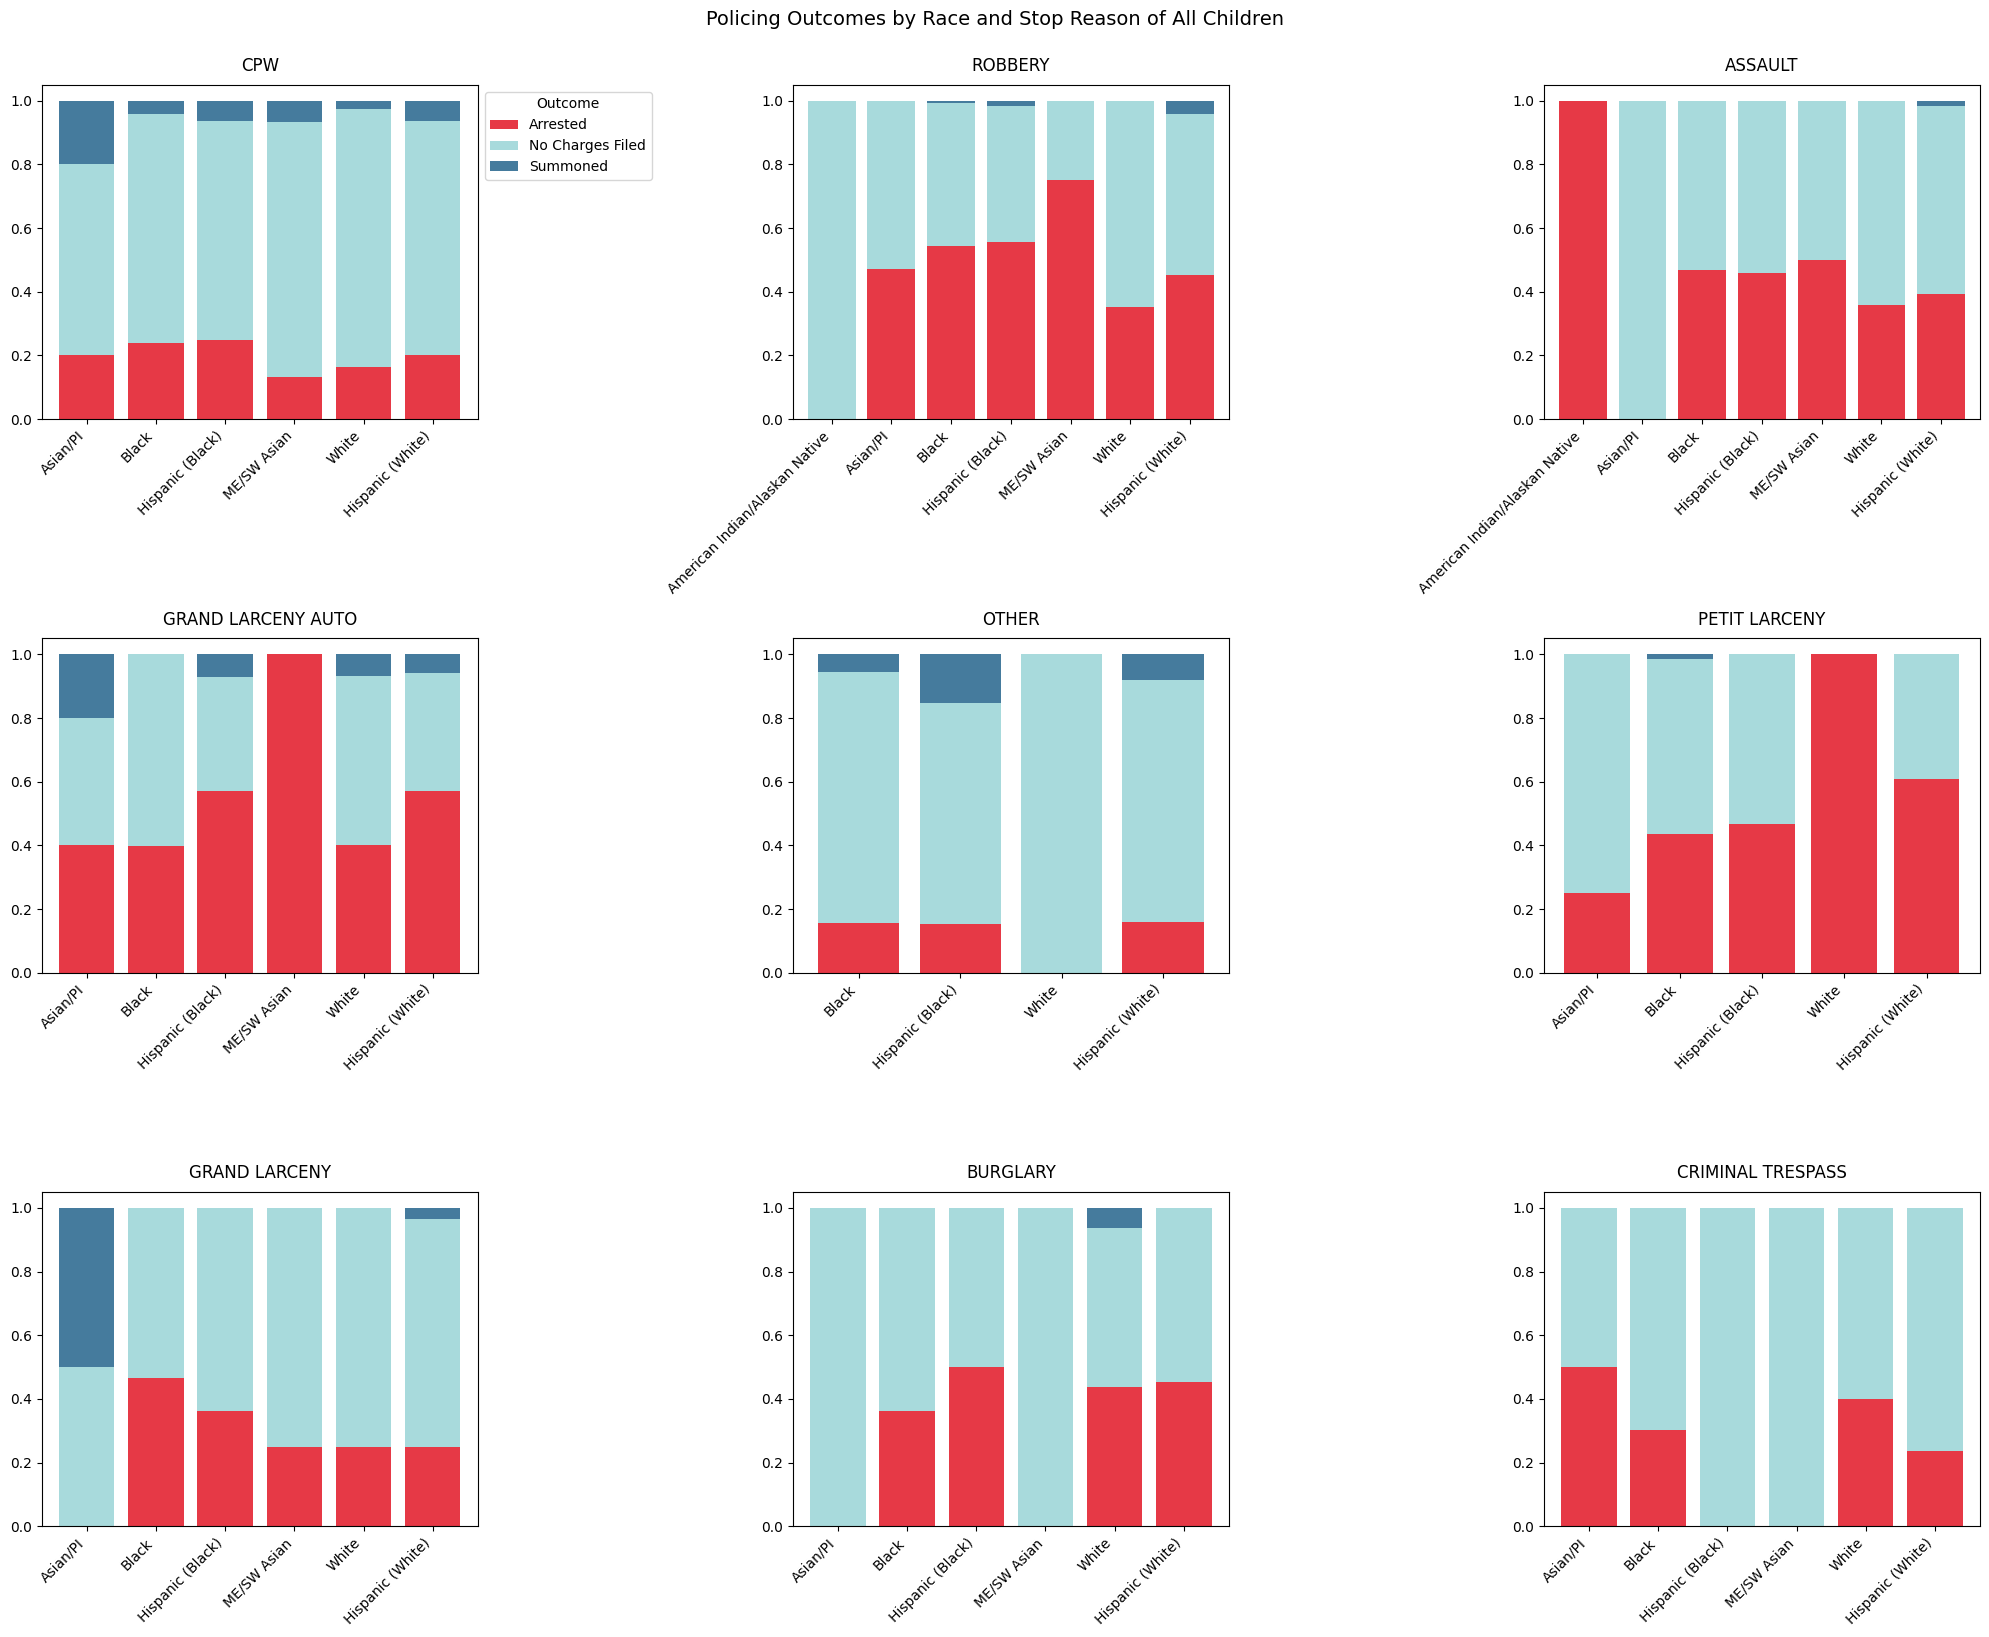

In [22]:
plot_stop_outcomes(all_children_df, n_reasons=9, figsize=(20,16), plot_title="Policing Outcomes by Race and Stop Reason of All Children")

In [23]:
# Feel free to take a look for yourself....
all_children_df

,SUSPECT_REPORTED_AGE,SUSPECT_RACE_DESCRIPTION,STOP_WAS_INITIATED,SUSPECTED_CRIME_DESCRIPTION,OFFICER_EXPLAINED_STOP_FLAG,OUTCOME_OF_STOP,FORCE_TYPE,STOP_LOCATION_BORO_NAME
2,17,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
3,13,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
4,14,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
5,17,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
11,17,WHITE,Based on Radio Run,BURGLARY,True,No Charges Filed,No Force,BROOKLYN
...,...,...,...,...,...,...,...,...
20247,17,BLACK HISPANIC,Based on Self Initiated,BURGLARY,True,No Charges Filed,No Force,BROOKLYN
20256,17,WHITE HISPANIC,Based on C/W on Scene,ASSAULT,True,No Charges Filed,No Force,BRONX
20258,14,BLACK,Based on Self Initiated,CPW,True,No Charges Filed,No Force,BRONX
20288,15,BLACK,Based on Radio Run,PETIT LARCENY,True,Arrested,No Force,BROOKLYN


### And it looks like an "early adulthood" for black and brown children
As we enter into the under 18 demographic, we begin to see the bifurcation of childhood based on race in that black and hispanic children are becoming targeted by the police themselves at nearly equal rates as being reported by someone in the child's community.  For black children, the number of stops from their pre-teen life to this teenage life is ~40x the amount of their earlier childhood.   

Moreover, for this age range, all children shot or tased are black and brown.  

## Placeholder for analysis for all NYers
TODO: FILLLLLLL

# Model Training (Why you're actually here)
While there's many ways to slice this cake, I am going to train and compare a multi-class Logistic Regression model with an Random Forest/Ensembling model.  Specifically, the models will be trained to predict the level of force a given demographic is likely to face.


In [24]:
def prepare_model_features(df):
    model_df = df.copy()
    
    # ===== 1. Core Temporal Features =====
    model_df['HOUR_OF_DAY'] = model_df['STOP_FRISK_TIME']
    model_df['IS_NIGHT'] = model_df['HOUR_OF_DAY'].between(20, 6).astype(int)
    model_df['IS_WEEKEND'] = model_df['STOP_FRISK_DATE'].dt.dayofweek >= 5
    
    # ===== 2. Demographic Enhancements =====
    model_df['IS_CHILD'] = (model_df['SUSPECT_REPORTED_AGE'] < 18).astype(int)
    model_df['AGE_GROUP'] = pd.cut(
        model_df['SUSPECT_REPORTED_AGE'],
        bins=[0, 12, 18, 30, 50, 100],
        labels=['child', 'teen', 'young_adult', 'adult', 'senior']
    )
    
    # ===== 3. Officer Behavior Context =====
    # Number of force types used
    # force_columns = [col for col in df.columns if 'PHYSICAL_FORCE' in col] # circular logic...
    # model_df['NUM_FORCE_TYPES'] = df[force_columns].sum(axis=1)
    
    # ===== 4. Location Intelligence =====
    # Borough-level force rates
    borough_force_rates = df.groupby('STOP_LOCATION_BORO_NAME')['OFFICER_USED_FORCE'].mean()
    model_df['BOROUGH_FORCE_RATE'] = model_df['STOP_LOCATION_BORO_NAME'].map(borough_force_rates)
    
    # ===== 5. Stop Context Features =====
    model_df['MULTIPLE_PERSONS_STOPPED'] = df['OTHER_PERSON_STOPPED_FLAG'].astype(int)
    
    # ===== 6. Officer Profile Features =====
    model_df['OFFICER_EXPERIENCE'] = np.where(
        df['ISSUING_OFFICER_RANK'].isin(['PO', 'PROBATIONARY POLICE OFFICER']),
        'junior',
        'senior'
    )
    
    # ===== 7. Target Engineering =====
    model_df['FORCE_WITHOUT_ACTION'] = (
        model_df['OFFICER_USED_FORCE'] & 
        (model_df['OUTCOME_OF_STOP'] == 'No Charges Filed')
    ).astype(int)
    
    # ===== 8. Smart Encoding =====
    # Categorical features with targeted encoding
    categorical_features = {
        'high_cardinality': [
            'SUSPECTED_CRIME_DESCRIPTION',
            'STOP_LOCATION_BORO_NAME'
        ],
        'low_cardinality': [
            'SUSPECT_RACE_DESCRIPTION',
            'SUSPECT_SEX',
            'STOP_WAS_INITIATED',
            'OFFICER_EXPERIENCE',
            'AGE_GROUP'
        ]
    }
    
    # Target encoding for high-cardinality features
    for col in categorical_features['high_cardinality']:
        encoder = model_df.groupby(col)['FORCE_WITHOUT_ACTION'].mean()
        model_df[f'{col}_ENCODED'] = model_df[col].map(encoder)
    
    # One-hot encode low-cardinality features
    encoded_df = pd.get_dummies(
        model_df[categorical_features['low_cardinality']],
        drop_first=True
    )
    
    # ===== 9. Final Feature Set =====
    numeric_features = [
        'SUSPECT_REPORTED_AGE',
        'SUSPECT_HEIGHT',
        'HOUR_OF_DAY',
        # 'NUM_FORCE_TYPES',
        'BOROUGH_FORCE_RATE'
    ]
    
    X = pd.concat([
        model_df[numeric_features],
        encoded_df,
        model_df[[
            'OFFICER_IN_UNIFORM_FLAG',
            'IS_NIGHT',
            'IS_WEEKEND',
            'IS_CHILD',
            # 'MULTIPLE_PERSONS_STOPPED'
        ]],
        model_df[[col for col in model_df.columns if '_ENCODED' in col]]
    ], axis=1)
    
    y = model_df['FORCE_WITHOUT_ACTION']
    
    # There might be a couple of null values left, clear them out assuming the delta isn't too high
    null_mask = X.isnull().any(axis=1)  # Boolean mask of rows with ANY nulls
    
    if null_mask.any():
        print(f"Dropping {null_mask.sum()} rows with null values")
        X_clean = X[~null_mask].copy()  # Keep only non-null rows
        y_clean = y[~null_mask].copy()
    else:
        X_clean, y_clean = X, y
    
    assert not X_clean.isnull().any().any(), "X still contains null values"
    assert len(X_clean) == len(y_clean), f"Length mismatch: X={len(X_clean)}, y={len(y_clean)}"
    
    return X_clean, y_clean

X, y = prepare_model_features(final_df)
# assert not X.isnull().any().any(), "Null values remain in features"

Dropping 2 rows with null values


In [25]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("Train distribution:", y_train.value_counts(normalize=True))
print("Test distribution:", y_test.value_counts(normalize=True))

Train distribution: FORCE_WITHOUT_ACTION
0    0.904029
1    0.095971
Name: proportion, dtype: float64
Test distribution: FORCE_WITHOUT_ACTION
0    0.903917
1    0.096083
Name: proportion, dtype: float64


[[2062 1607]
 [ 144  246]]
              precision    recall  f1-score   support

           0       0.93      0.56      0.70      3669
           1       0.13      0.63      0.22       390

    accuracy                           0.57      4059
   macro avg       0.53      0.60      0.46      4059
weighted avg       0.86      0.57      0.66      4059



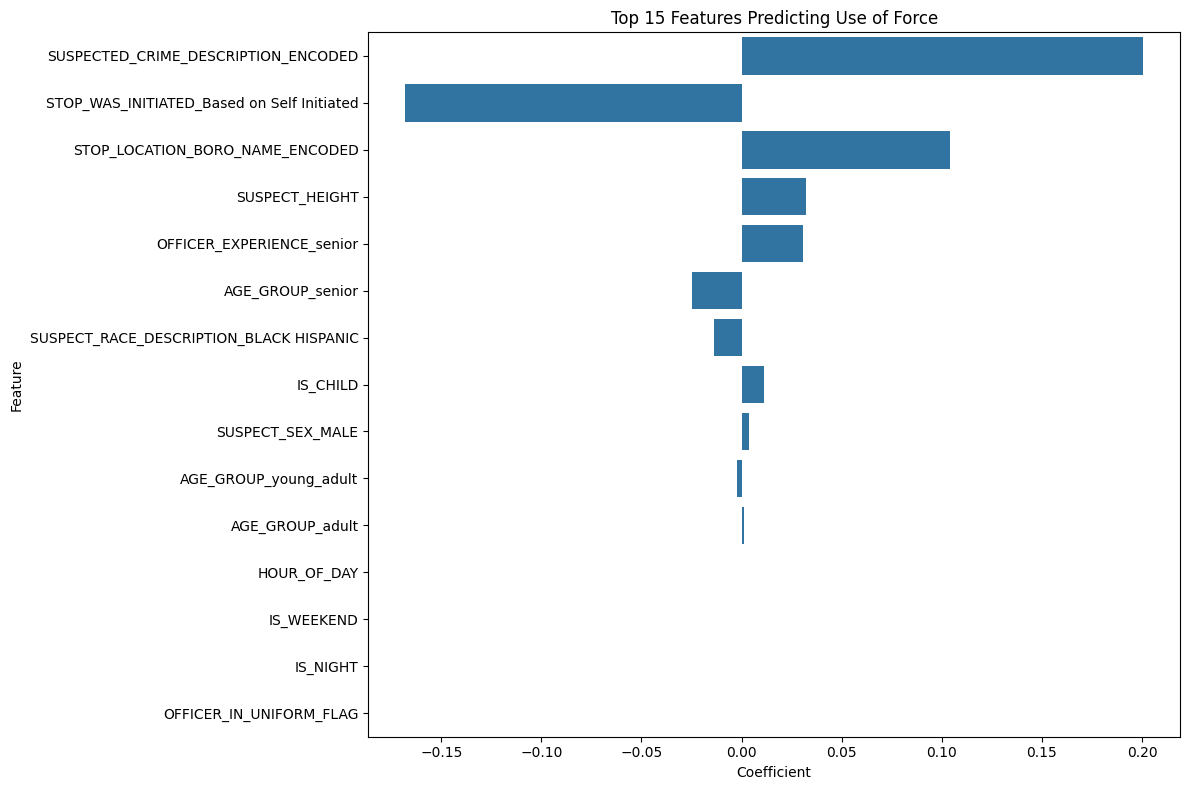

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
# lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, C= 0.01, penalty= 'l1', solver= 'liblinear')
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Extract and visualize feature importances
def visualize_features(X, model):
    feature_names = X.columns
    coefficients = model.coef_[0]
    importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    importance = importance.sort_values('Coefficient', key=abs, ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=importance.head(15))
    plt.title('Top 15 Features Predicting Use of Force')
    plt.tight_layout()
    plt.show()

visualize_features(X,lr_model)
# [[2175 1494]
#  [ 156  234]]
#               precision    recall  f1-score   support

#        False       0.93      0.59      0.72      3669
#         True       0.14      0.60      0.22       390

#     accuracy                           0.59      4059
#    macro avg       0.53      0.60      0.47      4059
# weighted avg       0.86      0.59      0.68      4059

In [27]:
## Jucing, not the most effective

from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_proba = lr_model.predict_proba(X_test_scaled)[:, 1] 

# Find threshold that maximizes F1 for minority class
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Apply optimized threshold
y_pred_opt = (y_proba >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.93      0.59      0.72      3669
           1       0.14      0.61      0.22       390

    accuracy                           0.59      4059
   macro avg       0.54      0.60      0.47      4059
weighted avg       0.86      0.59      0.68      4059



Best params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best recall: 0.5905144694533762
[[2062 1607]
 [ 144  246]]
              precision    recall  f1-score   support

           0       0.93      0.56      0.70      3669
           1       0.13      0.63      0.22       390

    accuracy                           0.57      4059
   macro avg       0.53      0.60      0.46      4059
weighted avg       0.86      0.57      0.66      4059



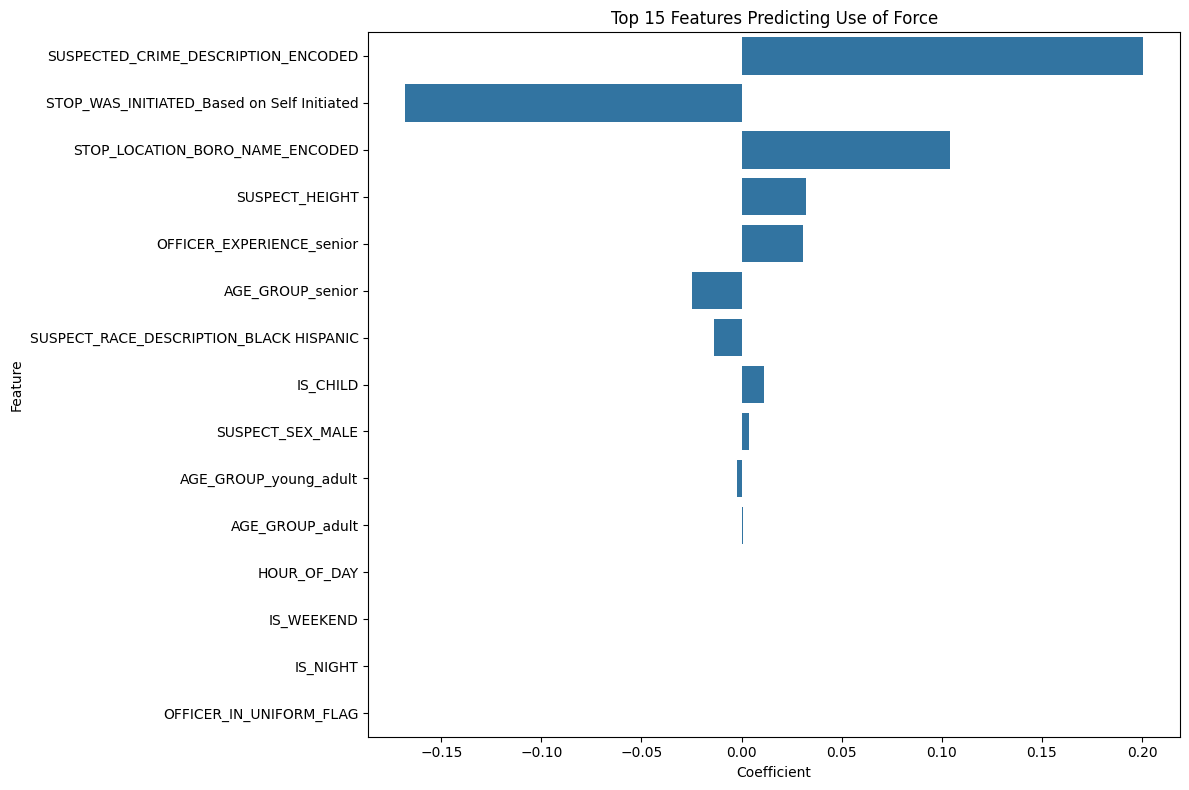

In [41]:
# scratch
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse regularization strength
    'penalty': ['l1', 'l2'],           # Regularization type
    'solver': ['liblinear', 'saga']     # Solvers that support L1
}

grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='recall',  # Prioritize catching true positives
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best recall:", grid.best_score_)

y_pred = grid.predict(X_test_scaled)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
visualize_features(X,grid.best_estimator_)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Adjust class weights in Random Forest
from sklearn.ensemble import RandomForestClassifier

lr_model = RandomForestClassifier(
    class_weight={0: 1, 1: 10},  # 10x penalty for missing class 1
    # class_weight="balanced",
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Extract and visualize feature importances
# feature_names = X.columns
# coefficients = lr_model.coef_[0]
# importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# importance = importance.sort_values('Coefficient', key=abs, ascending=False)

# plt.figure(figsize=(12, 8))
# sns.barplot(x='Coefficient', y='Feature', data=importance.head(15))
# plt.title('Top 15 Features Predicting Use of Force')
# plt.tight_layout()
# plt.show()
# [[3618   41]
#  [ 375   25]]
#               precision    recall  f1-score   support

#            0       0.91      0.99      0.95      3659
#            1       0.38      0.06      0.11       400

#     accuracy                           0.90      4059
#    macro avg       0.64      0.53      0.53      4059
# weighted avg       0.85      0.90      0.86      4059


[[3626   43]
 [ 371   19]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3669
           1       0.31      0.05      0.08       390

    accuracy                           0.90      4059
   macro avg       0.61      0.52      0.52      4059
weighted avg       0.85      0.90      0.86      4059



AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

lr_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)  # More aggressive weighting

lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Extract and visualize feature importances
# feature_names = X.columns
# coefficients = lr_model.coef_[0]
# importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# importance = importance.sort_values('Coefficient', key=abs, ascending=False)

# plt.figure(figsize=(12, 8))
# sns.barplot(x='Coefficient', y='Feature', data=importance.head(15))
# plt.title('Top 15 Features Predicting Use of Force')
# plt.tight_layout()
# plt.show()
# [[3614   45]
#  [ 386   14]]
#               precision    recall  f1-score   support

#            0       0.90      0.99      0.94      3659
#            1       0.24      0.04      0.06       400

#     accuracy                           0.89      4059
#    macro avg       0.57      0.51      0.50      4059
# weighted avg       0.84      0.89      0.86      4059

[[3628   41]
 [ 374   16]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3669
           1       0.28      0.04      0.07       390

    accuracy                           0.90      4059
   macro avg       0.59      0.51      0.51      4059
weighted avg       0.85      0.90      0.86      4059



# Misc Notes/Parking Lot
- Menacing filter is quite disproportionate
- [ ] Parallel work for 13+, then total
- [ ] Model training
- [ ] Analysis


In [31]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

# Define models
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, C= 0.01, penalty= 'l1', solver= 'liblinear')
xgb = XGBClassifier(scale_pos_weight=10, eval_metric='aucpr')

# Soft voting ensemble
ensemble = VotingClassifier(
    estimators=[('lr', logreg), ('xgb', xgb)],
)

param_grid = {
    'voting': ['soft', 'hard'],  # Inverse regularization strength
     'weights': [[0.1, 0.9],[0.3, 0.7],[0.5, 0.5],[0.9, 0.1]] ,
}

# Train
grid_ensemble = GridSearchCV(
    ensemble,
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='recall',  # Prioritize catching true positives
    n_jobs=-1
)
grid_ensemble.fit(X_train_scaled, y_train)

print("Best params:", grid_ensemble.best_params_)
print("Best recall:", grid_ensemble.best_score_)


y_pred = grid_ensemble.predict(X_test_scaled)


# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# [[2866  803]
#  [ 253  137]]
#               precision    recall  f1-score   support

#            0       0.92      0.78      0.84      3669
#            1       0.15      0.35      0.21       390

#     accuracy                           0.74      4059
#    macro avg       0.53      0.57      0.53      4059
# weighted avg       0.84      0.74      0.78      4059

# Best params: {'voting': 'hard', 'weights': [0.9, 0.1]}
# Best recall: 0.5475121609365983
# [[2198 1471]
#  [ 170  220]]
#               precision    recall  f1-score   support

#            0       0.93      0.60      0.73      3669
#            1       0.13      0.56      0.21       390

#     accuracy                           0.60      4059
#    macro avg       0.53      0.58      0.47      4059
# weighted avg       0.85      0.60      0.68      4059

/home/yao/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'voting': 'hard', 'weights': [0.9, 0.1]}
Best recall: 0.5905144694533762
[[2062 1607]
 [ 144  246]]
              precision    recall  f1-score   support

           0       0.93      0.56      0.70      3669
           1       0.13      0.63      0.22       390

    accuracy                           0.57      4059
   macro avg       0.53      0.60      0.46      4059
weighted avg       0.86      0.57      0.66      4059



In [32]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

# Keep your best LR model
lr = LogisticRegression(
    C=0.01, 
    penalty='l1', 
    solver='liblinear',
    class_weight={0:1, 1:10}
)

# Add RandomForest
rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,
    n_estimators=100
)

ensemble = VotingClassifier(
    estimators=[('lr', grid), ('rf', rf)],
    voting='soft'  # Uses probabilities
)
ensemble.fit(X_train_scaled, y_train)

y_pred = ensemble.predict(X_test_scaled)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# [[2009 1660]
#  [ 129  261]]
#               precision    recall  f1-score   support

#            0       0.94      0.55      0.69      3669
#            1       0.14      0.67      0.23       390

#     accuracy                           0.56      4059
#    macro avg       0.54      0.61      0.46      4059
# weighted avg       0.86      0.56      0.65      4059

[[2031 1638]
 [ 137  253]]
              precision    recall  f1-score   support

           0       0.94      0.55      0.70      3669
           1       0.13      0.65      0.22       390

    accuracy                           0.56      4059
   macro avg       0.54      0.60      0.46      4059
weighted avg       0.86      0.56      0.65      4059



In [33]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Create LightGBM dataset
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

# LightGBM params tuned for imbalance
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'aucpr',
    'is_unbalance': True,  # Automatically adjusts class weights
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'random_state': 42
}

# Train model
lgb_model = lgb.train(params, train_data, num_boost_round=200, valid_sets=[test_data])

# Predict
y_proba = lgb_model.predict(X_test_scaled)
y_pred = (y_proba >= 0.5).astype(int)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Optional: PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("LGBM PR AUC:", pr_auc)


[[2574 1095]
 [ 207  183]]
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      3669
           1       0.14      0.47      0.22       390

    accuracy                           0.68      4059
   macro avg       0.53      0.59      0.51      4059
weighted avg       0.85      0.68      0.74      4059

LGBM PR AUC: 0.153959679510286


In [34]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Create CatBoost model
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    scale_pos_weight=10,  # Balances positive class
    verbose=0,
    random_seed=42
)

# If you still want to use scaled features:
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)
# cat_model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), early_stopping_rounds=20)

# Predict
y_proba = cat_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Optional: PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("CATBoost PR AUC:", pr_auc)


[[1844 1825]
 [ 112  278]]
              precision    recall  f1-score   support

           0       0.94      0.50      0.66      3669
           1       0.13      0.71      0.22       390

    accuracy                           0.52      4059
   macro avg       0.54      0.61      0.44      4059
weighted avg       0.86      0.52      0.61      4059

CATBoost PR AUC: 0.16555122808184358


In [42]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

# Keep your best LR model
# Add RandomForest
rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,
    n_estimators=100
)

ensemble = VotingClassifier(
    estimators=[('lr', cat_model), ('rf', rf)],
    voting='soft'  # Uses probabilities
)
ensemble.fit(X_train_scaled, y_train)

y_pred = ensemble.predict(X_test_scaled)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# [[2009 1660]
#  [ 129  261]]
#               precision    recall  f1-score   support

#            0       0.94      0.55      0.69      3669
#            1       0.14      0.67      0.23       390

#     accuracy                           0.56      4059
#    macro avg       0.54      0.61      0.46      4059
# weighted avg       0.86      0.56      0.65      4059

[[2509 1160]
 [ 185  205]]
              precision    recall  f1-score   support

           0       0.93      0.68      0.79      3669
           1       0.15      0.53      0.23       390

    accuracy                           0.67      4059
   macro avg       0.54      0.60      0.51      4059
weighted avg       0.86      0.67      0.74      4059



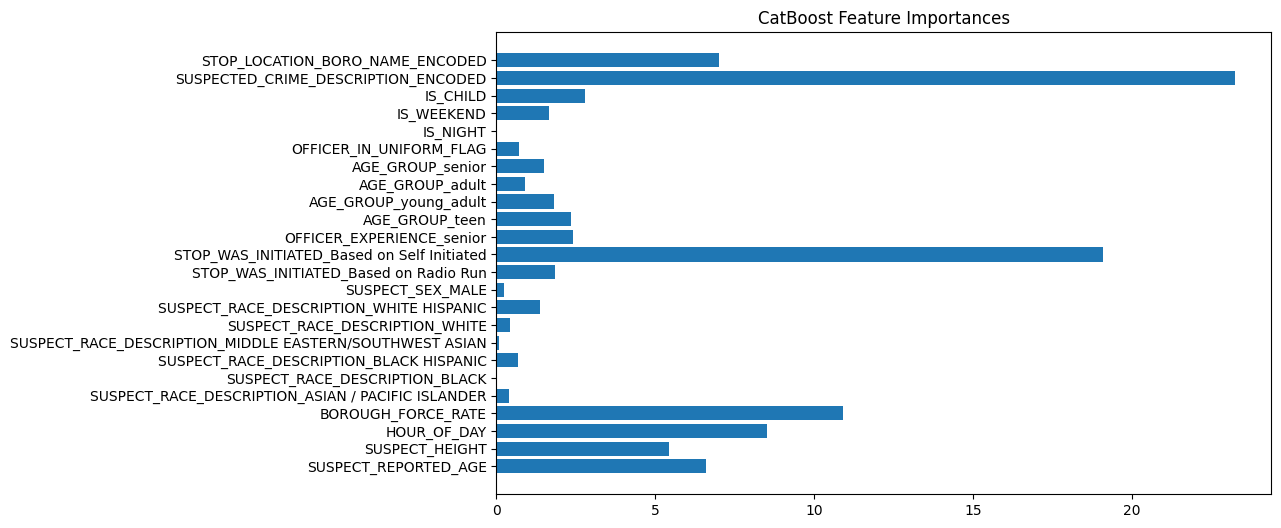

(Index(['SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT', 'HOUR_OF_DAY',
        'BOROUGH_FORCE_RATE',
        'SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER',
        'SUSPECT_RACE_DESCRIPTION_BLACK',
        'SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC',
        'SUSPECT_RACE_DESCRIPTION_MIDDLE EASTERN/SOUTHWEST ASIAN',
        'SUSPECT_RACE_DESCRIPTION_WHITE',
        'SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC', 'SUSPECT_SEX_MALE',
        'STOP_WAS_INITIATED_Based on Radio Run',
        'STOP_WAS_INITIATED_Based on Self Initiated',
        'OFFICER_EXPERIENCE_senior', 'AGE_GROUP_teen', 'AGE_GROUP_young_adult',
        'AGE_GROUP_adult', 'AGE_GROUP_senior', 'OFFICER_IN_UNIFORM_FLAG',
        'IS_NIGHT', 'IS_WEEKEND', 'IS_CHILD',
        'SUSPECTED_CRIME_DESCRIPTION_ENCODED',
        'STOP_LOCATION_BORO_NAME_ENCODED'],
       dtype='object'),
 array([ 6.59895287,  5.42332696,  8.53190548, 10.91530545,  0.39324168,
         0.        ,  0.66362601,  0.08893752,  0.43393869,  1.37676799,
       

In [35]:
import matplotlib.pyplot as plt

feature_importances = cat_model.get_feature_importance()
feature_names = X_train.columns  # Or raw column list if you used cat_features

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title("CatBoost Feature Importances")
plt.show()
X_train.columns, cat_model.get_feature_importance()

/home/yao/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


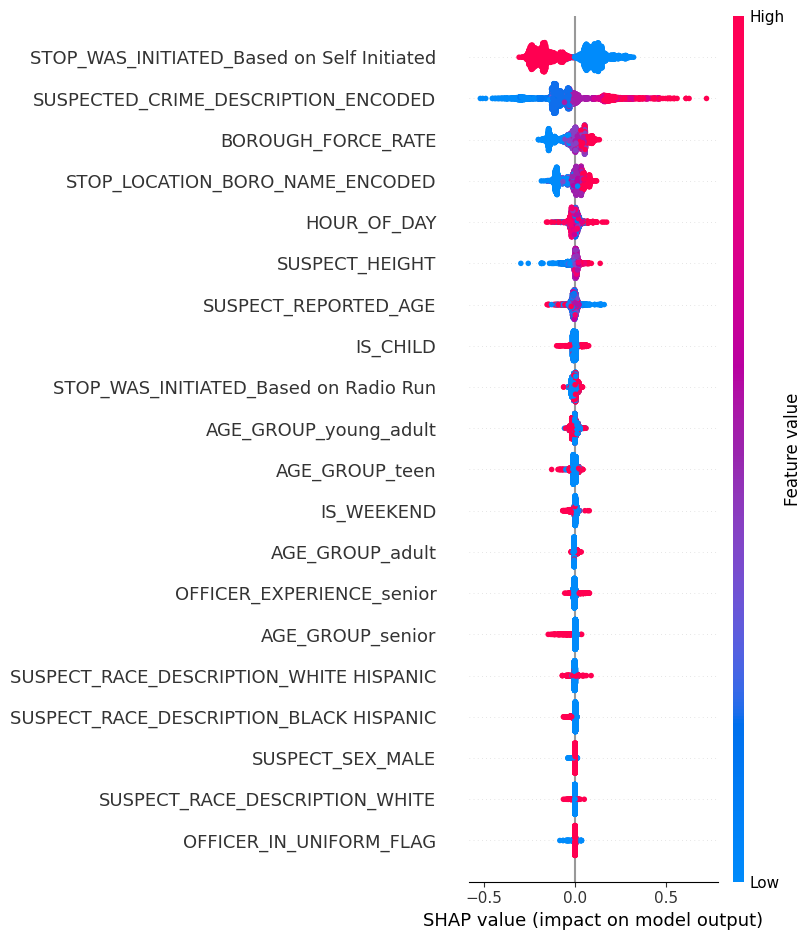

In [36]:
import shap
from catboost import Pool

# Optional: specify categorical columns if you used raw data
# categorical_cols = ['SUSPECT_RACE_DESCRIPTION', 'SUSPECT_SEX', 'STOP_WAS_INITIATED']  # Update this as needed

# Prepare Pool object (CatBoost's data wrapper)
test_pool = Pool(data=X_test, label=y_test)

# Compute SHAP values (automatically uses TreeSHAP)
shap_values = cat_model.get_feature_importance(test_pool, type='ShapValues')

# Drop the last column (it's the expected value repeated for all rows)
shap_values = shap_values[:, :-1]

# Initialize SHAP explainer object (required for plotting)
explainer = shap.Explainer(cat_model)

# Plot global summary
shap.summary_plot(shap_values, X_test)


In [37]:
# Scratch
final_df["FORCE_TYPE"].value_counts()

FORCE_TYPE
No Force                15633
Handcuffs                2998
Firearm Drawn             584
Restraint Used            493
Other Physical Force      475
Taser                     103
Weapon Impact               8
Pepper Spray                1
Name: count, dtype: int64

# References
1. Research
    1. [NYCLU Stop and Frisk Dataset](https://www.nyclu.org/data/stop-and-frisk-data)
        1. [NYCLU Stop and Frisk Analysis regarding children](https://www.nyclu.org/data/closer-look-stop-and-frisk-nyc)
    1. [John Jay College of Criminal Justice](https://datacollaborativeforjustice.org/research-resources/)
    1. [NYPD Monitor's 2024 EOY Review](https://www.nypdmonitor.org/wp-content/uploads/2025/02/2025.02.26-Floyd-2024-Year-End-Letter.pdf)
        1. 4/10 Stops are unreported, so the data here isn't even fully representative 
1. Data
    1. [Stop and Frisk Dataset](https://data.cityofnewyork.us/Public-Safety/The-Stop-Question-and-Frisk-Data/ftxv-d5ix/about_data)
    1. [NYC Demographic Data](https://www.nyc.gov/content/planning/pages/resources/datasets/american-community-survey)
    1. [NYC Population Statistics](https://popfactfinder.planning.nyc.gov/explorer/cities/NYC?censusTopics=populationSexAgeDensity)
    1. [CDC Growth Charts](https://www.cdc.gov/growthcharts/data/set1clinical/cj41c021.pdf)
1. Misc.
    1. [Previous analysis and predictive model training from 2020](https://github.com/VeeLeeKoh/Stop-and-Frisk-Data-Analysis/) 